In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)


In [2]:
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

In [3]:
from torchvision import datasets, transforms

# CIFAR-10の訓練用データセットを読み込み、
# 以下の2つの前処理を適用する：
# 1. ToTensor(): PIL画像をPyTorchのTensor形式に変換（ピクセル値を0〜1にスケーリング）
# 2. Normalize(): 画像のRGBチャンネルごとに、訓練セット全体の平均と標準偏差を用いて正規化

data_path = "../data-unversioned/p1ch7/"

cifar10 = datasets.CIFAR10(
    data_path,  # データを保存するディレクトリ
    train=True,  # 訓練用データセットを指定
    download=False,  # 既にダウンロード済みのため再取得しない
    transform=transforms.Compose(
        [  # 複数の変換を順に適用
            transforms.ToTensor(),  # PIL → Tensor（float32, 範囲: 0〜1）
            transforms.Normalize(  # チャンネルごとの正規化
                (0.4915, 0.4823, 0.4468),  # 平均（R, G, B）
                (0.2470, 0.2435, 0.2616),  # 標準偏差（R, G, B）
            ),
        ]
    ),
)

In [4]:
cifar10_val = datasets.CIFAR10(
    data_path,
    train=False,
    download=False,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616)),
        ]
    ),
)

In [5]:
# CIFAR-10の中から "airplane" (label=0) と "bird" (label=2) のみを抽出し、
# ラベルを {0: 0, 2: 1} に変換して2クラス分類用のデータセットを作成する。

label_map = {0: 0, 2: 1}  # 元のラベルを2クラス用にマッピング
class_names = ["airplane", "bird"]  # 使用するクラス名

# 訓練データから該当クラスのみを抽出し、ラベルを変換
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]

# 検証データから該当クラスのみを抽出し、ラベルを変換
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [6]:
import torch.nn as nn

n_out = 2  # 出力クラス数（airplane, bird の2クラス）

# CIFAR-10画像（3チャンネル, 32×32ピクセル = 3072次元）を入力とする多層パーセプトロン（MLP）モデルを構築
model = nn.Sequential(
    nn.Linear(3072, 512),  # 入力層: 3072次元 → 中間層: 512ユニット
    nn.Tanh(),  # 活性化関数: 双曲線正接関数（非線形変換）
    nn.Linear(512, n_out),  # 出力層: 512ユニット → 出力クラス数（2クラス）
)

In [7]:
def softmax(x):
    # ソフトマックス関数：
    # 各要素の指数を取り、全要素の指数の合計で割ることで、
    # 出力が確率分布（合計1になる）になるようにする
    return torch.exp(x) / torch.exp(x).sum()

In [8]:
x = torch.tensor([1.0, 2.0, 3.0])

softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [9]:
softmax(x).sum()

tensor(1.)

In [10]:
# dim=1: 各行ごとにsoftmaxを適用（バッチ内の各サンプルに対して）
softmax = nn.Softmax(dim=1)

x = torch.tensor([[1.0, 2.0, 3.0], [1.0, 2.0, 3.0]])

output = softmax(x)
print(output)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])


In [11]:
model = nn.Sequential(
    nn.Linear(3072, 512), nn.Tanh(), nn.Linear(512, 2), nn.Softmax(dim=1)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8628641..2.029448].


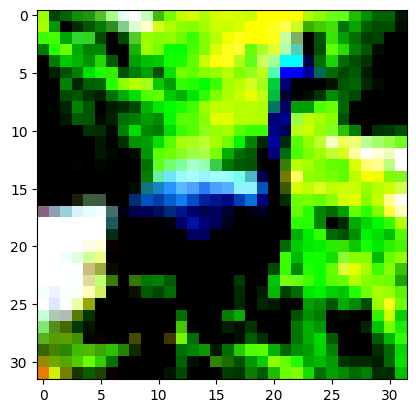

In [12]:
img, _ = cifar2[0]

plt.imshow(img.permute(1, 2, 0))
plt.show()

In [13]:
# img: CIFAR画像などのテンソル (例: shape=(3, 32, 32))

# view(-1): 画像テンソルを1次元にフラット化（3×32×32 = 3072次元ベクトル）
# unsqueeze(0): バッチ次元を追加（shape: (1, 3072)）
img_batch = img.view(-1).unsqueeze(0)

In [14]:
out = model(img_batch)
out

tensor([[0.4784, 0.5216]], grad_fn=<SoftmaxBackward0>)

In [15]:
# `out` はモデルの出力テンソル（例：shape = [バッチサイズ, クラス数]）
# 各サンプルごとに、最もスコアの高いクラス（最大値のインデックス）を取得する

_, index = torch.max(out, dim=1)

# `index` は各サンプルについて、最大値（＝予測クラス）のインデックスを持つテンソル
# 例：torch.tensor([1, 0, 2]) など（バッチ内3サンプルの予測クラスがそれぞれ1, 0, 2）
index

tensor([1])

In [16]:
# 入力画像（3×32×32 = 3072次元）を2クラスに分類する全結合ニューラルネットワークの定義
# 活性化関数としてTanhを使用し、最後にLogSoftmaxで対数確率を出力する

model = nn.Sequential(
    nn.Linear(3072, 512),  # 入力層: 画像のピクセル値を512次元に変換
    nn.Tanh(),  # 非線形変換: Tanh関数で活性化（範囲：-1〜1）
    nn.Linear(512, 2),  # 出力層: 2クラス（例：飛行機 vs 鳥）に変換
    nn.LogSoftmax(
        dim=1
    ),  # 出力: 各クラスの対数確率を返す（交差エントロピー損失と組み合わせる前提）
)

In [17]:
# 損失関数の定義：負の対数尤度損失（Negative Log Likelihood Loss）
# 出力がlog-softmax形式（nn.LogSoftmax）であるモデルと一緒に使用する

loss = nn.NLLLoss()

In [18]:
img, label = cifar2[0]

out = model(img.view(-1).unsqueeze(0))

loss(out, torch.tensor([label]))

tensor(0.5077, grad_fn=<NllLossBackward0>)

In [21]:
import torch.optim as optim

model = nn.Sequential(
    nn.Linear(3072, 512), nn.Tanh(), nn.Linear(512, 2), nn.LogSoftmax(dim=1)
)

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 10

for epoch in range(n_epochs):
    for img, label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 6.079278
Epoch: 1, Loss: 7.598315
Epoch: 2, Loss: 2.108224
Epoch: 3, Loss: 10.835946
Epoch: 4, Loss: 7.567768
Epoch: 5, Loss: 6.629907
Epoch: 6, Loss: 12.274743
Epoch: 7, Loss: 4.974216
Epoch: 8, Loss: 11.026301
Epoch: 9, Loss: 9.617123


In [22]:
# DataLoaderの定義：学習用データ（cifar2）をミニバッチに分けて供給する
# - batch_size=64：一度に64枚の画像を読み込む
# - shuffle=True：毎エポックごとにデータの順番をシャッフルして汎化性能を高める

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

In [24]:
# CIFAR-2データセットの2クラス分類モデルの学習ループ
# 入力：3x32x32画像を1次元（3072次元）にflattenして全結合ネットワークに通す
# ネットワーク構造：Linear(3072→128) → Tanh → Linear(128→2) → LogSoftmax
# 最適化手法：確率的勾配降下法（SGD）、損失関数：負の対数尤度損失（NLLLoss）

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = nn.Sequential(
    nn.Linear(3072, 128),  # 入力層（3072次元）から中間層（128次元）
    nn.Tanh(),  # 活性化関数（双曲線正接）
    nn.Linear(128, 2),  # 出力層（2クラス分類）
    nn.LogSoftmax(dim=1),  # 出力を対数ソフトマックスに変換（NLLLossに対応）
)

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()
n_epochs = 100

# 学習ループ
for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        # 画像を1次元（バッチサイズ x 3072）にflatten
        outputs = model(imgs.view(imgs.shape[0], -1))  # 順伝播
        loss = loss_fn(outputs, labels)  # 損失計算

        optimizer.zero_grad()  # 勾配初期化
        loss.backward()  # 勾配計算（逆伝播）
        optimizer.step()  # パラメータ更新

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))  # 各エポック終了時に損失表示

Epoch: 0, Loss: 0.419396
Epoch: 1, Loss: 0.353266
Epoch: 2, Loss: 0.358240
Epoch: 3, Loss: 0.400695
Epoch: 4, Loss: 0.429707
Epoch: 5, Loss: 0.471407
Epoch: 6, Loss: 0.319822
Epoch: 7, Loss: 0.148314
Epoch: 8, Loss: 0.376174
Epoch: 9, Loss: 0.364801
Epoch: 10, Loss: 0.398969
Epoch: 11, Loss: 0.154077
Epoch: 12, Loss: 0.216580
Epoch: 13, Loss: 0.263219
Epoch: 14, Loss: 0.449941
Epoch: 15, Loss: 0.605801
Epoch: 16, Loss: 0.392557
Epoch: 17, Loss: 0.449708
Epoch: 18, Loss: 0.264848
Epoch: 19, Loss: 0.494987
Epoch: 20, Loss: 0.141137
Epoch: 21, Loss: 0.246362
Epoch: 22, Loss: 0.632205
Epoch: 23, Loss: 0.298713
Epoch: 24, Loss: 0.220602
Epoch: 25, Loss: 0.292281
Epoch: 26, Loss: 0.315676
Epoch: 27, Loss: 0.226785
Epoch: 28, Loss: 0.199365
Epoch: 29, Loss: 0.269055
Epoch: 30, Loss: 0.054453
Epoch: 31, Loss: 0.206067
Epoch: 32, Loss: 0.252586
Epoch: 33, Loss: 0.125446
Epoch: 34, Loss: 0.196721
Epoch: 35, Loss: 0.182928
Epoch: 36, Loss: 0.114497
Epoch: 37, Loss: 0.150746
Epoch: 38, Loss: 0.210

In [25]:
# CIFAR-2分類モデルの訓練スクリプト
# - モデル：全結合ニューラルネットワーク（2層）
# - 活性化関数：Tanh
# - 出力：2クラス用のLogSoftmax
# - 損失関数：負の対数尤度損失（NLLLoss）
# - 最適化手法：SGD（学習率 0.01）

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = nn.Sequential(
    nn.Linear(3072, 512),  # 入力画像（3x32x32 = 3072）→中間層（512）
    nn.Tanh(),  # Tanh活性化関数
    nn.Linear(512, 2),  # 中間層→出力層（2クラス）
    nn.LogSoftmax(dim=1),  # 出力に対してLogSoftmaxを適用
)

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)  # SGDによる最適化
loss_fn = nn.NLLLoss()  # 負の対数尤度損失（LogSoftmaxに対応）
n_epochs = 100

# 学習ループ（100エポック）
for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))  # 画像をflattenして入力
        loss = loss_fn(outputs, labels)  # 損失を計算

        optimizer.zero_grad()  # 勾配を初期化
        loss.backward()  # 誤差逆伝播による勾配計算
        optimizer.step()  # パラメータを更新

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))  # エポックごとの損失を表示

Epoch: 0, Loss: 0.512133
Epoch: 1, Loss: 0.555352
Epoch: 2, Loss: 0.436777
Epoch: 3, Loss: 0.351507
Epoch: 4, Loss: 0.277133
Epoch: 5, Loss: 0.523798
Epoch: 6, Loss: 0.413200
Epoch: 7, Loss: 0.392049
Epoch: 8, Loss: 0.502444
Epoch: 9, Loss: 0.569020
Epoch: 10, Loss: 0.437988
Epoch: 11, Loss: 0.464160
Epoch: 12, Loss: 0.403606
Epoch: 13, Loss: 0.366443
Epoch: 14, Loss: 0.258983
Epoch: 15, Loss: 0.443610
Epoch: 16, Loss: 0.270309
Epoch: 17, Loss: 0.460021
Epoch: 18, Loss: 0.198564
Epoch: 19, Loss: 0.424789
Epoch: 20, Loss: 0.199077
Epoch: 21, Loss: 0.398109
Epoch: 22, Loss: 0.270855
Epoch: 23, Loss: 0.321322
Epoch: 24, Loss: 0.225489
Epoch: 25, Loss: 0.276578
Epoch: 26, Loss: 0.193953
Epoch: 27, Loss: 0.135430
Epoch: 28, Loss: 0.444134
Epoch: 29, Loss: 0.174300
Epoch: 30, Loss: 0.161188
Epoch: 31, Loss: 0.225456
Epoch: 32, Loss: 0.298732
Epoch: 33, Loss: 0.317133
Epoch: 34, Loss: 0.173825
Epoch: 35, Loss: 0.191741
Epoch: 36, Loss: 0.087191
Epoch: 37, Loss: 0.125472
Epoch: 38, Loss: 0.257

In [26]:
# 学習済みモデルによる訓練データ上での分類精度評価
# - 評価時は勾配を追跡しないよう torch.no_grad() を使用
# - DataLoader の shuffle=False により順序を保ったまま評価

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)

correct = 0  # 正解数のカウント
total = 0  # 総サンプル数

with torch.no_grad():  # 評価中は勾配計算を無効化
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))  # 入力画像をflattenして予測
        _, predicted = torch.max(outputs, dim=1)  # 出力最大のクラスを予測値とする
        total += labels.shape[0]
        correct += int((predicted == labels).sum())  # 正解との一致数を加算

print("Accuracy: %f" % (correct / total))  # 精度（Accuracy）を表示

Accuracy: 0.999500


In [27]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

print("Accuracy: %f" % (correct / total))

Accuracy: 0.817500


In [28]:
model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2),
    nn.LogSoftmax(dim=1),
)

In [29]:
model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2),
)

loss_fn = nn.CrossEntropyLoss()

In [31]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2),
)

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 10

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.364529
Epoch: 1, Loss: 0.607475
Epoch: 2, Loss: 0.274583
Epoch: 3, Loss: 0.461011
Epoch: 4, Loss: 0.447233
Epoch: 5, Loss: 0.593781
Epoch: 6, Loss: 0.311108
Epoch: 7, Loss: 0.437446
Epoch: 8, Loss: 0.278297
Epoch: 9, Loss: 0.240712


In [32]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

print("Accuracy: %f" % (correct / total))

Accuracy: 0.803600


In [33]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

print("Accuracy: %f" % (correct / total))

Accuracy: 0.789500
